# Contenido

1. **Carga de librerías y datos**
    - 1.a. Librerías
    - 1.b. Carga de datos
2. **Clustering**
    - 2.a. Visualización

# 1. Carga de librerías y datos

#  1.a. Librerías

In [1]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import seaborn as sns
import plotly.express as px
import matplotlib.colors as mcolors
from IPython.display import Image
import plotly.io as pio

# 1.b. Carga de datos

In [2]:
datos = pd.read_csv('../../../1-DATOS/3-DATOS DE RESULTADOS/ANALISIS DESCRIPTIVO/medias_semanales_por_hora.csv', index_col=[0, 1], header=0)

In [3]:
# Escalar las series para estandarizar su media y varianza
scaler = TimeSeriesScalerMeanVariance()
datos_scaled = scaler.fit_transform(datos.T) 

In [4]:
localizacion = pd.read_parquet('../../../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/GEOLOCALIZACION.parquet')
localizacion.set_index(localizacion.columns[0], inplace=True)
localizacion = localizacion[['lat', 'lon']]

# 2. Clustering

In [5]:
# Aplicar KMeans con DTW para crear 3 clusters
kmeans_dtw = TimeSeriesKMeans(n_clusters=3, metric="euclidean", random_state=0)
clusters = kmeans_dtw.fit_predict(datos_scaled)

df_clusters = pd.DataFrame(datos.T)
df_clusters['Cluster'] = clusters

# Guardar los resultados
result = df_clusters.iloc[:,[-1]]
result = result.reset_index()
result.columns = ["station_id", "Cluster"]

result.to_csv('../../../1-DATOS/3-DATOS DE RESULTADOS/ANALISIS DESCRIPTIVO/info_clusters.csv')

# Calcular la serie representativa (media) de cada cluster
representativas = df_clusters.groupby('Cluster').mean()

In [6]:
fechas = [' '.join(map(str, idx)) for idx in datos.index]
dias_semana = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

fechas_reducidas = [
    dias_semana.get(fecha.split()[0], fecha.split()[0]) if i % 24 == 0 else ''
    for i, fecha in enumerate(fechas)
]

# 2.a. Visualización

**SERIES POR CLUSTER**

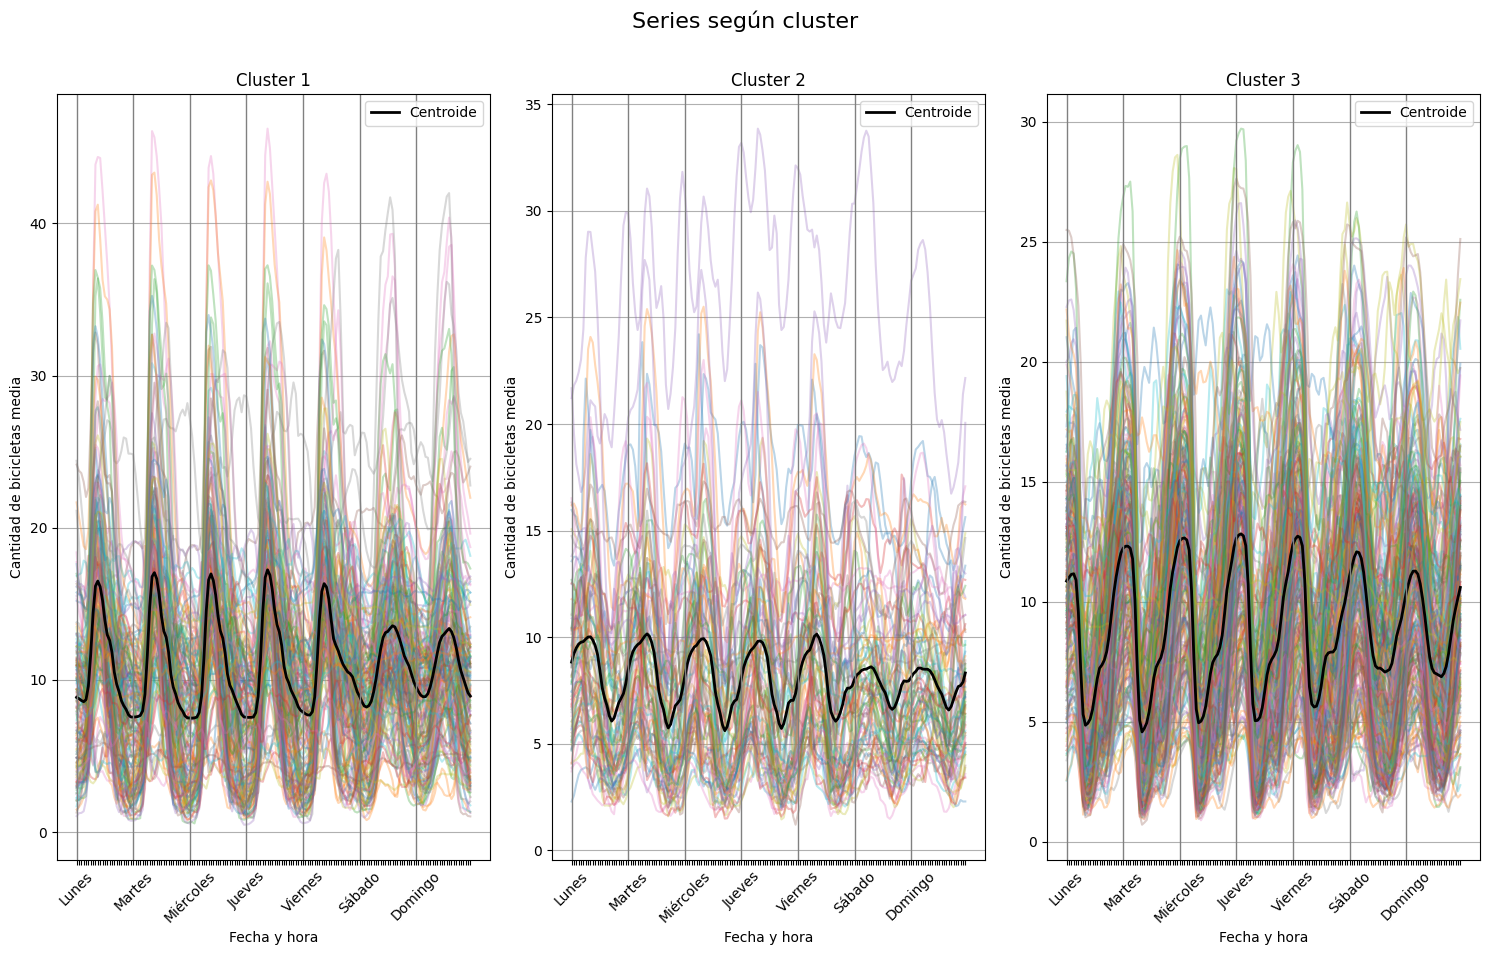

In [7]:
plt.figure(figsize=(15, 10))
colors = sns.color_palette("husl", 3)  
plt.suptitle("Series según cluster", fontsize=16, y=0.95) 

ticks_diarios = [i for i in range(len(fechas)) if i % 24 == 0]

for cluster in range(3):
    plt.subplot(1, 3, cluster + 1)  # Crear una cuadrícula de subgráficas (1x3 para 3 clusters)
    for serie in df_clusters[df_clusters['Cluster'] == cluster].index:
        plt.plot(fechas, datos.loc[:, serie], alpha=0.3)  
    plt.plot(fechas, representativas.loc[cluster], color='black', linewidth=2, label='Centroide') 

    for tick in ticks_diarios:
        plt.axvline(x=tick, color='gray', linestyle='-', linewidth=1)
    plt.xticks(ticks=range(len(fechas)), labels=fechas_reducidas, rotation=45)  
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Fecha y hora')
    plt.ylabel('Cantidad de bicicletas media')
    plt.legend(loc='upper right')
    plt.grid(axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.94]) 
# plt.savefig("series_por_cluster.png", format="png", dpi=300)  
plt.show()

**CENTROIDES**

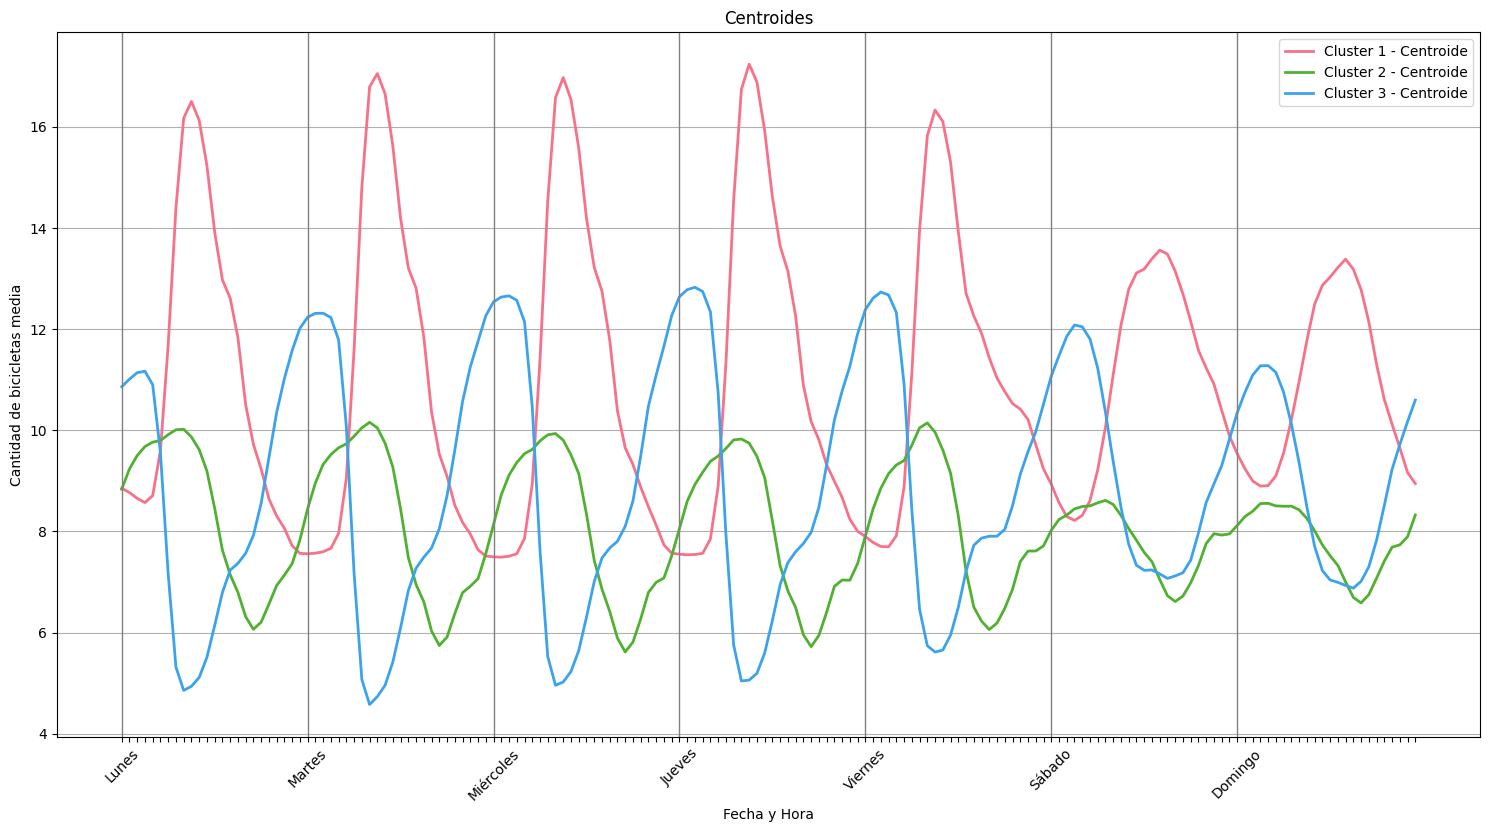

In [8]:
plt.figure(figsize=(15, 8))
colors = sns.color_palette("husl", 3)

fechas = [' '.join(map(str, idx)) for idx in datos.index]
fechas_reducidas = [
    dias_semana.get(fecha.split()[0], fecha.split()[0]) if i % 24 == 0 else ''
    for i, fecha in enumerate(fechas)
]

ticks_diarios = [i for i in range(len(fechas)) if i % 24 == 0]

# Graficar cada serie representativa
for cluster in range(3):
    plt.plot(fechas, representativas.iloc[cluster], color=colors[cluster], linewidth=2, label=f'Cluster {cluster + 1} - Centroide')

plt.title('Centroides')
plt.xlabel('Fecha y Hora')
plt.ylabel('Cantidad de bicicletas media')
plt.legend(loc='upper right')
plt.grid(axis='y')  

for tick in ticks_diarios:
    plt.axvline(x=tick, color='gray', linestyle='-', linewidth=1)

plt.tight_layout()
plt.xticks(ticks=range(len(fechas)), labels=fechas_reducidas, rotation=45)
# plt.savefig("centroides.png", format="png", dpi=300)  # Cambia "png" al formato que prefieras
plt.show()


**LOCALIZACIÓN**

In [9]:
localizacion.index = localizacion.index.astype(str)
df_clusters.index = df_clusters.index.astype(str)

info = pd.merge(localizacion, df_clusters['Cluster'], left_index=True, right_index=True, how='inner')
info['Cluster'] = info['Cluster'].astype('category')

# Ordenar
info_sorted = info.sort_values(by='Cluster')
info_sorted['Cluster'] = info_sorted['Cluster'].astype(int) 
info_sorted['Cluster'] = info_sorted['Cluster'] + 1
info_sorted['Cluster'] = info_sorted['Cluster'].astype('category') 

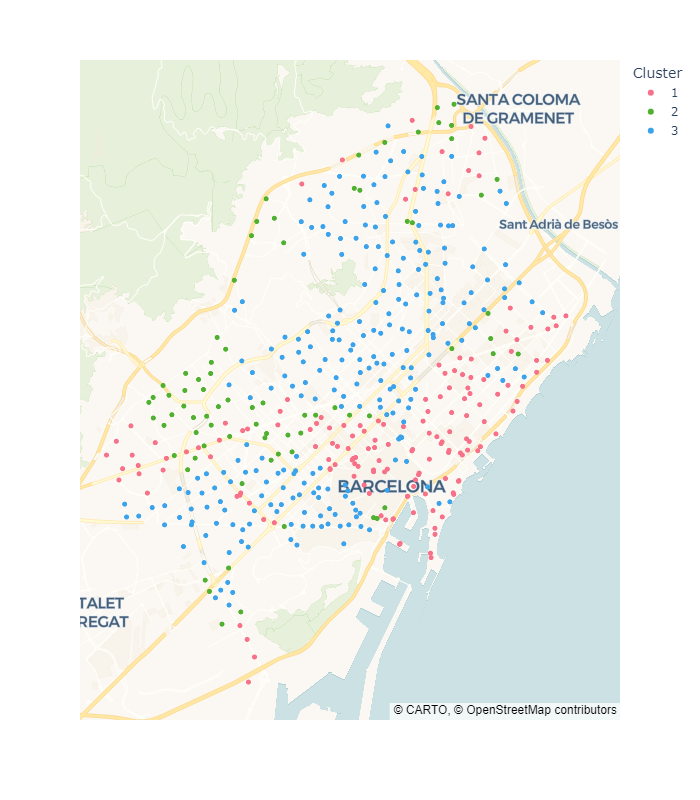

In [10]:
hex_colors = [mcolors.to_hex(c) for c in colors]

fig = px.scatter_map(info_sorted, lat="lat", lon="lon", color="Cluster", color_discrete_sequence = hex_colors, zoom=11.5, height=800)
# fig.write_image("Ubicación estaciones según cluster.png", engine="kaleido")
# fig.show() # Muestra la imagen en formato interactivo
static_image = pio.to_image(fig, format="png", engine="kaleido")
Image(static_image) # Muestra la imagen estática

**CENTROIDE Y SERIE REPRESENTATIVA DEL CLUSTER**

In [11]:
representativas_indices = []
representativas = []
idx = []

for cluster_num in range(3):
    cluster_data = datos_scaled[clusters == cluster_num]  
    media_cluster = np.mean(cluster_data, axis=0)
    
    # Encontrar la serie más cercana a la media usando distancia euclidiana
    closest_idx = np.argmin([np.linalg.norm(media_cluster - serie) for serie in cluster_data])
    representativas.append(cluster_data[closest_idx])
    index_in_cluster = np.where(clusters == cluster_num)[0][closest_idx]
    representativas_indices.append(index_in_cluster)
    idx.append(closest_idx)

Con los datos escalados:

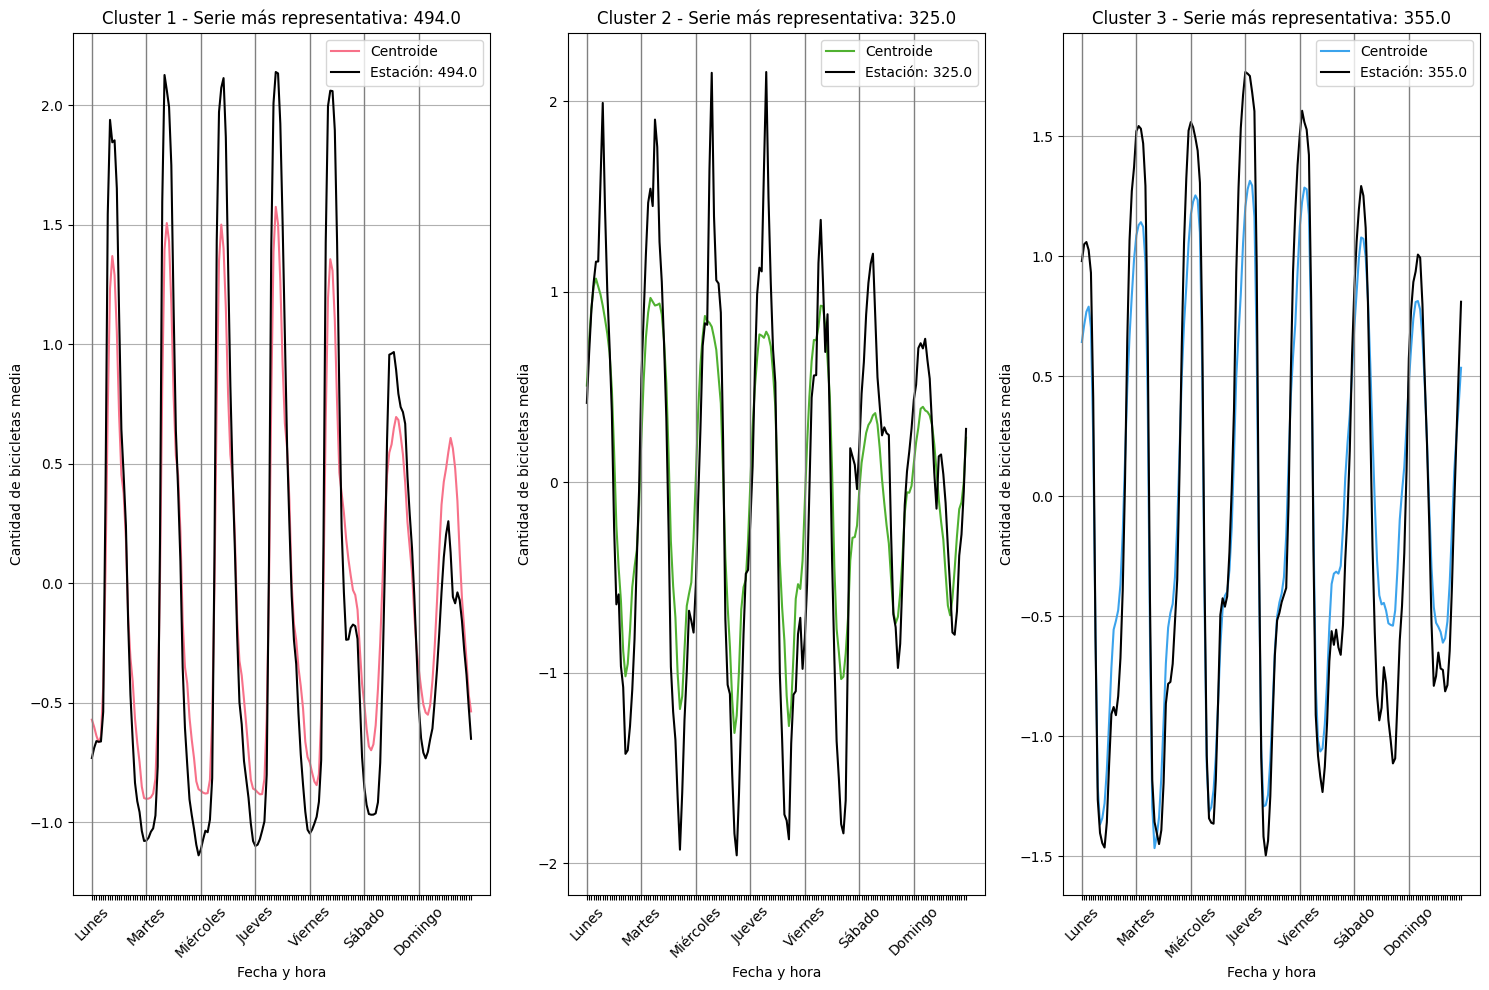

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10)) 
axes = axes.ravel()  

ticks_diarios = [i for i in range(len(fechas)) if i % 24 == 0]

for cluster_num in range(3):
    ax = axes[cluster_num]  
    
    ax.plot(np.mean(datos_scaled[clusters == cluster_num], axis=0).ravel(), label="Centroide", color=colors[cluster_num])
    ax.plot(representativas[cluster_num].ravel(), label=f"Estación: {df_clusters.iloc[representativas_indices[cluster_num]].name}", color="black")
    
    ax.set_title(f"Cluster {cluster_num + 1} - Serie más representativa: {df_clusters.iloc[representativas_indices[cluster_num]].name}")
    ax.set_xticks(range(len(fechas)))
    ax.set_xticklabels(fechas_reducidas, rotation=45)

    for tick in ticks_diarios:
        ax.axvline(x=tick, color='gray', linestyle='-', linewidth=1)
    ax.legend()
    ax.grid(axis = 'y')
    ax.set_xlabel('Fecha y hora')
    ax.set_ylabel('Cantidad de bicicletas media')
    
plt.tight_layout()
# plt.savefig("centroide_representativa.png", format="png", dpi=300) 
plt.show()

Sin escalar:

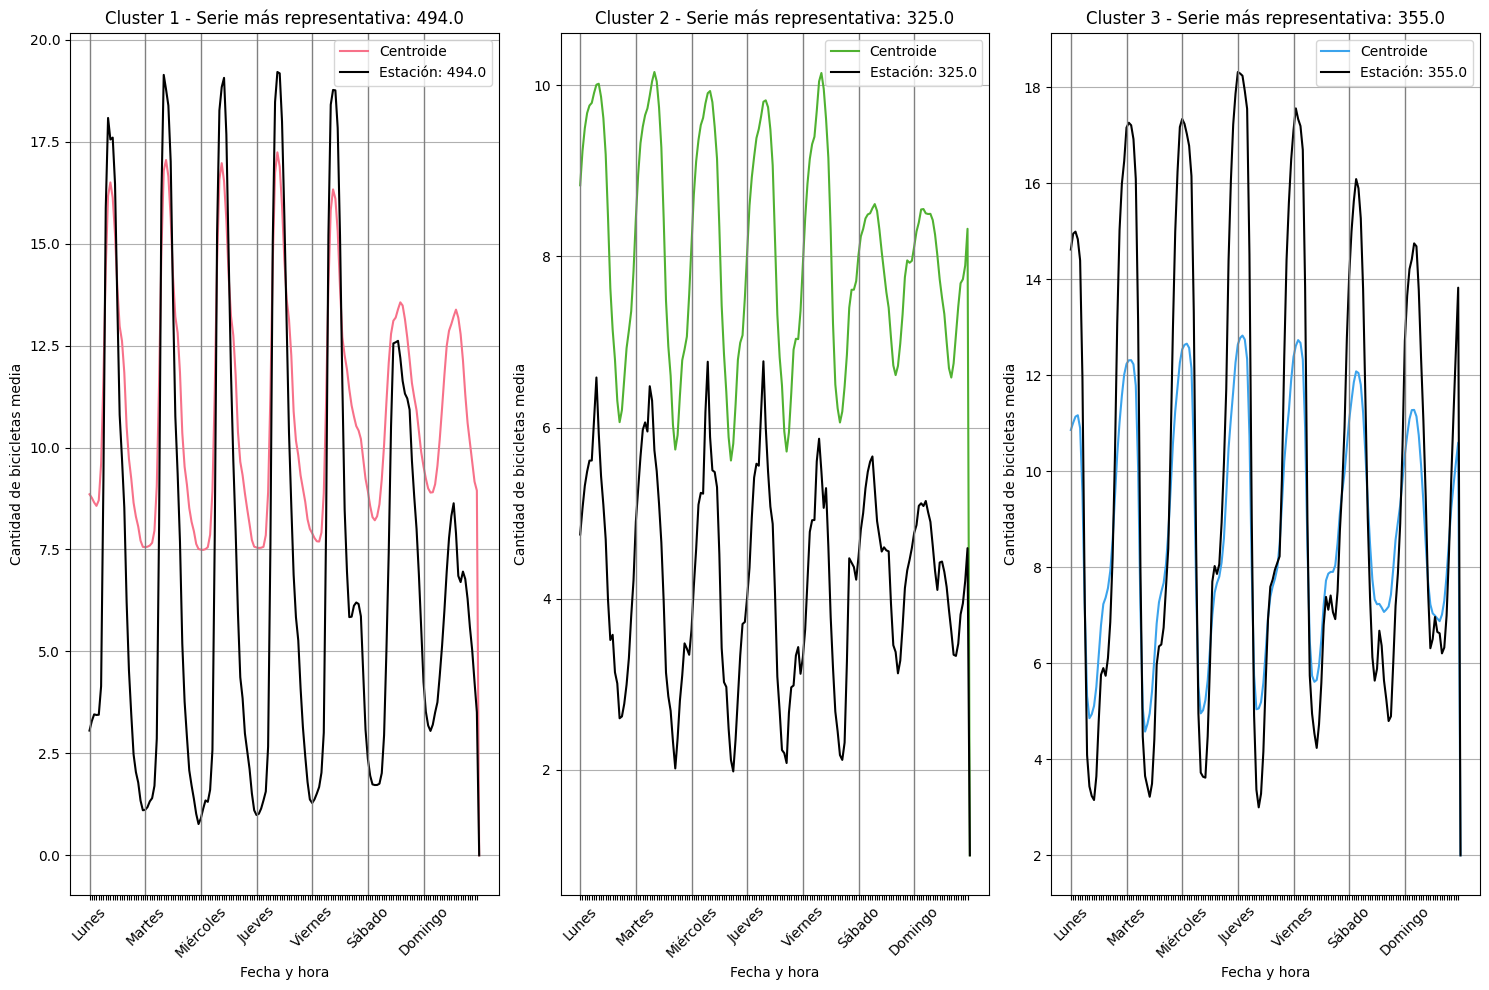

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10)) 
axes = axes.ravel()  
ticks_diarios = [i for i in range(len(fechas)) if i % 24 == 0]

for cluster_num in range(3):
    cluster = df_clusters[df_clusters.Cluster == cluster_num]
    ax = axes[cluster_num] 

    ax.plot(np.mean(df_clusters[clusters == cluster_num], axis=0).ravel(), label="Centroide", color=colors[cluster_num])
    ax.plot(cluster.iloc[idx[cluster_num]].ravel(), label=f"Estación: {df_clusters.iloc[representativas_indices[cluster_num]].name}", color="black")
    
    ax.set_title(f"Cluster {cluster_num + 1} - Serie más representativa: {df_clusters.iloc[representativas_indices[cluster_num]].name}")
    ax.set_xticks(range(len(fechas)))
    ax.set_xticklabels(fechas_reducidas, rotation=45)
    
    for tick in ticks_diarios:
        ax.axvline(x=tick, color='gray', linestyle='-', linewidth=1)
    ax.legend()
    ax.grid(axis = 'y')
    ax.set_xlabel('Fecha y hora')
    ax.set_ylabel('Cantidad de bicicletas media')

plt.tight_layout()
plt.show()